# **Double Pendulum Simulation**

This notebook will solve the double-pendulum problem without using the small-angle approximation.

Created by: Robert Von Holle. Last edited: 4/29/21.

In [2]:
%matplotlib inline

import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Double-Pendulum.svg/800px-Double-Pendulum.svg.png')

The above image (taken from the Wikipedia page on the double pendulum) displays the setup of the double pendulum. We are looking to find $\theta_1$ and $\theta_2$ as functions of time. For the sake of simplicity, we will assume that the two rods of length $L_1$ and $L_2$ are massless.

We will begin by finding the Legrangian of this system. The x and y coordinates of the two bobs are:

$x_1 = L_1 sin \theta_1 \\
x_2 = x_1 + L_2 sin \theta_2 \\
y_1 = L_1 cos \theta_1 \\
y_2 = y_1 + L_2 cos \theta_2$

And the time derivatives of these equations are:

$\dot x_1 = L_1\dot\theta_1 cos \theta_1 \\
\dot x_2 = L_1\dot\theta_1 cos \theta_1 + L_2\dot\theta_2 cos \theta_2 \\
\dot y_1 = - L_1\dot\theta_1 sin \theta_1 \\
\dot y_2 = - L_1\dot\theta_1 sin \theta_1 - L_2\dot\theta_2 sin \theta_2$

The kinetic energy of this system is $T = \frac{1}{2} m_1 v_1^2 + \frac{1}{2} m_2 v_2^2
= \frac{1}{2} m_1 (\dot x_1^2 + \dot y_1^2) + \frac{1}{2} m_2 (\dot x_2^2 + \dot y_2^2)$. When the above equations are plugged in, this becomes:

$T = \frac{1}{2} m_1 L_1^2 \dot\theta_1^2 + \frac{1}{2} m_2 L_2^2 \dot\theta_2^2 +
\frac{1}{2} m_2 [L_1^2 \dot\theta_1^2 + 2 L_1 L_2 cos(\theta_1 - \theta_2) \dot\theta_1 \dot\theta_2]$

Likewise, the potential energy of this system is $U = - m_1 g y_1 - m_2 g y_2$. When the above equations are plugged in, this becomes:

$U = -(m_1 + m_2) L_1 g cos \theta_1 - m_2 L_2 g cos \theta_2$

Thus, the lagrangian $\mathcal{L} = T - U$ of this system is:

$\mathcal{L} = \frac{1}{2} m_1 L_1^2 \dot\theta_1^2 + \frac{1}{2} m_2 L_2^2 \dot\theta_2^2 +
\frac{1}{2} m_2 [L_1^2 \dot\theta_1^2 + 2 L_1 L_2 cos(\theta_1 - \theta_2) \dot\theta_1 \dot\theta_2]
+ (m_1 + m_2) L_1 g cos \theta_1 + m_2 L_2 g cos \theta_2$

By applying the Euler-Lagrange equations, we obtain:

$(m_1 + m_2) L_1^2 \ddot\theta_1 + m_2 L_1 L_2 cos(\theta_1 - \theta_2) \ddot\theta_2
+ m_2 L_1 L_2 sin(\theta_1 - \theta_2) (\dot\theta_1 - \dot\theta_2)
+ m_2 L_1 L_2 sin(\theta_1 - \theta_2) \dot\theta_1 \dot\theta_2 + (m_1 + m_2) L_1 g sin \theta_1 = 0 \\
m_2 L_2^2 \ddot\theta_2 + m_2 L_1 L_2 [cos(\theta_1 - \theta_2) \ddot\theta_1 + sin(\theta_1 - \theta_2)
(\dot\theta_1 - \dot\theta_2)] - m_2 L_1 L_2 sin (\theta_1 - \theta_2) \dot\theta_1 \dot\theta_2
+ m_2 L_2 g sin \theta_2 = 0$

These simplify to:

$(m_1 + m_2)L_1 \ddot\theta_1 + m_2 L_2 \ddot\theta_2 cos (\theta_1 - \theta_2)
+ m_2 L_2 \dot\theta_2^2 sin (\theta_1 - \theta_2) + (m_1 + m_2) g sin \theta_1 = 0 \\
m_2 L_2 \ddot\theta_2 + m_2 L_1 \ddot\theta_1 cos (\theta_1 - \theta_2)
- m_2 L_1 \dot\theta_1 sin (\theta_1 - \theta_2) + m_2 g sin \theta_2 = 0$

Solving for $\ddot\theta_1$ and $\ddot\theta_2$, we obtain:

$\ddot\theta_1 = \frac{m_2 g sin \theta_2 cos (\theta_1 - \theta_2) - m_2 sin (\theta_1 - \theta_2)
[L_1 \dot\theta_1^2 cos (\theta_1 - \theta_2) + L_2 \dot\theta_2^2] - (m_1 + m_2) g sin \theta_1}
{L_1 [m_1 + m_2 sin^2 (\theta_1 - \theta_2)]} \\
\ddot\theta_2 = \frac{(m_1 + m_2) [L_1 \dot\theta_1^2 sin (\theta_1 - \theta_2) - g sin \theta_2 +
g sin \theta_1 cos(\theta_1 - \theta_2)] + m_2 L_2 \dot\theta_2^2 sin (\theta_1 - \theta_2) cos (\theta_1 - \theta_2)}
{L_2 [m_1 + m_2 sin^2 (\theta_1 - \theta_2)]}$

Because the differential equation solver we will be using requires systems of first order differential equations, we will replace $\dot\theta_1$ and $\dot\theta_2$ with $z_1$ and $z_2$ such that $\ddot\theta_1 = \dot z_1$ and $\ddot\theta_2 = \dot z_2$.


## Let's actually code it now

Below is a modification of the class LagrangianPendulum from the notebook Lagrangian_pendulum adapted for use with a double pendulum.

In [4]:
class DoublePendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a double pendulum (no driving or damping).
     
    Parameters
    ----------
    L_1 : float
        length of the upper pendulum rod
    L_2 : float
        length of the lower pendulum rod
    g : float
        gravitational acceleration at the earth's surface
    m_1 : float
        mass of the upper pendulum bob
    m_2 : float
        mass of the lower pendulum bob

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0, abserr, relerr)
        Returns the solution to the initial value problem given the initial values.
    """
    def __init__(self, L1=1., L2=1., g=1., m1=1., m2=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.m1 = m1
        self.m2 = m2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dtheta1/dt, dtheta1_dot/dt, dtheta2/dt, dtheta2_dot/dt]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = theta1(t), y[1] = dtheta1/dt,
                y[2] = theta2(t), y[3] = dtheta/dt
            
        Returns
        -------
        theta1_dot(t)
        theta1_ddot(t)
        theta2_dot(t)
        theta2_ddot(t)
        """
        theta1 = y[0]
        z1 = y[1]
        theta2 = y[2]
        z2 = y[3]
        
        # This is just so each variable name takes up less space
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.m1 = m1
        self.m2 = m2
        
        dif = theta1 - theta2
        
        z1_dot = (m2*g*np.sin(theta2)*np.cos(dif) - m2*np.sin(dif)*(L2*z1**2*np.cos(dif) + L2*z2**2) \
                  - (m1 + m2)*g*np.sin(theta1)) / (L1*(m1 + m2*np.sin(dif)**2))
        z2_dot = ((m1 + m2)*(L1*z1**2*np.sin(dif) - g*np.sin(theta2) + g*np.sin(theta1)*np.cos(dif)) \
                  + m2*L2*z2**2*np.sin(dif)*np.cos(dif)) / (L1*(m1 + m2*np.sin(dif)**2))
        
        return z1, z1_dot, z2, z2_dot
    
    def solve_ode(self, t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0,
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [theta1_0, theta1_dot_0, theta2_0, theta2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        theta1, z1, theta2, z2 = solution.y

        return theta1, z1, theta2, z2
    
    def calc_E(self, y):
        """
        Return the total energy of the system
        """
        theta1, theta1_dot, theta2, theta2_dot = y.T
        
        V = -(self.m1 + self.m2)*self.L1*self.g*np.cos(theta1) \
            - self.m2*self.L2*self.g*np.cos(theta2)
        T = 0.5*self.m1*self.L1**2*theta1_dot**2 + 0.5*self.m2*self.L2**2*theta2_dot**2 \
            + 0.5*self.m2*(self.L1**2*theta1_dot**2 + \
            2*self.L1*self.L2*np.cos(theta1 - theta2)*theta1_dot*theta2_dot)

Next is the generic plotting function and the start/stop indices taken from the same notebook.

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [6]:
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

## Plot the double pendulum

In [7]:
# Labels for individual plot axes
theta_vs_time_labels = (r'$t$', r'$\theta(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# We will use the simple default values here
L1 = 1.
L2 = 1.
g = 1.
m1 = 1.
m2 = 1.

# Instantiate a double pendulum 
dp1 = DoublePendulum(L1=L1, L2=L2, g=g, m1=m1, m2=m2)


(<AxesSubplot:xlabel='$t$', ylabel='$\\theta(t)$'>,
 <matplotlib.lines.Line2D at 0x7f56ab799110>)

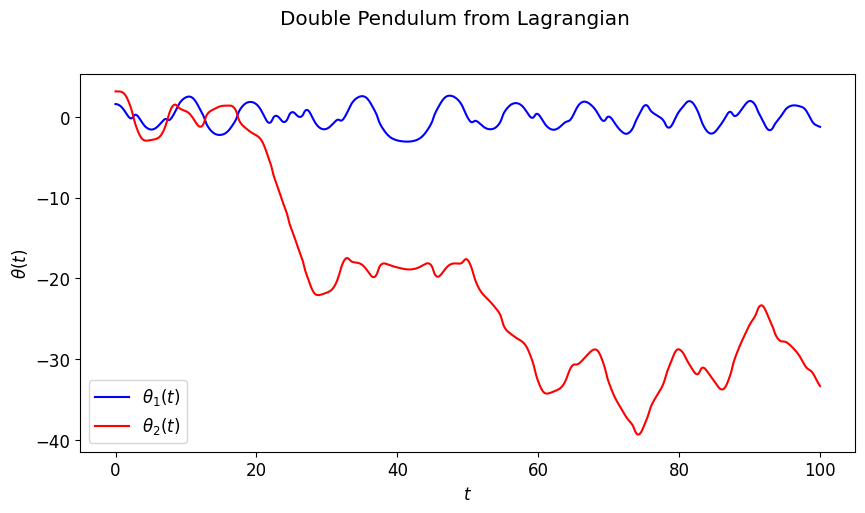

In [8]:
# Define initial conditions
theta1_0 = np.pi / 2
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.

# Find the theta functions
theta1, theta1_dot, theta2, theta2_dot = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)

# Plot the theta functions
fig = plt.figure(figsize=(10,5))
overall_title = 'Double Pendulum from Lagrangian'
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta1[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='blue', 
            label=r'$\theta_1(t)$', 
            ax=ax_a)
plot_y_vs_x(t_pts[start : stop], theta2[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='red', 
            label=r'$\theta_2(t)$', 
            ax=ax_a)    

We will now show that this motion is chaotic by showing that it has sensitivity to initial conditions. For one set of $\theta_1$ and $\theta_2$ (we will call them set A), the initial velocities of both penulums are zero. For another set of $\theta_1$ and $\theta_2$ (we will call them set B), I have assigned a very small but non-zero initial velocity to the upper pendulum.

(<AxesSubplot:xlabel='$t$', ylabel='$\\theta(t)$'>,
 <matplotlib.lines.Line2D at 0x7f56ab2f0490>)

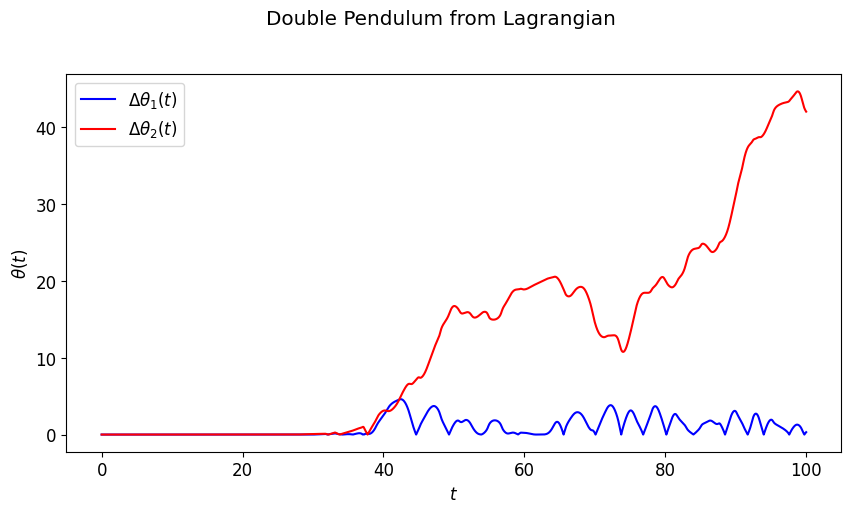

In [9]:
# Define initial conditions
theta1_0 = np.pi / 2
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.

# Find the theta functions
theta1a, theta1a_dot, theta2a, theta2a_dot = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
theta1b, theta1b_dot, theta2b, theta2b_dot = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0+0.001, theta2_0, theta2_dot_0)

# Plot the theta functions
fig = plt.figure(figsize=(10,5))
overall_title = 'Double Pendulum from Lagrangian'
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(theta1a[start : stop] - theta1b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='blue', 
            label=r'$\Delta\theta_1(t)$', 
            ax=ax_a)
plot_y_vs_x(t_pts[start : stop], np.abs(theta2a[start : stop] - theta2b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='red', 
            label=r'$\Delta\theta_2(t)$', 
            ax=ax_a)    

This plot shows that there is no initial difference between the motion of the two double pendulums, but shortly after t = 30, a great difference appears between the instances of $\theta_2$. Although there is also a difference in the instances of $\theta_1$ as well, it is notably smaller at large times. Let us now see what happens if we keep the initial velocities the same between the two pendulums but change the initial positions of the bobs.

(<AxesSubplot:xlabel='$t$', ylabel='$\\theta(t)$'>,
 <matplotlib.lines.Line2D at 0x7f56ab0b6310>)

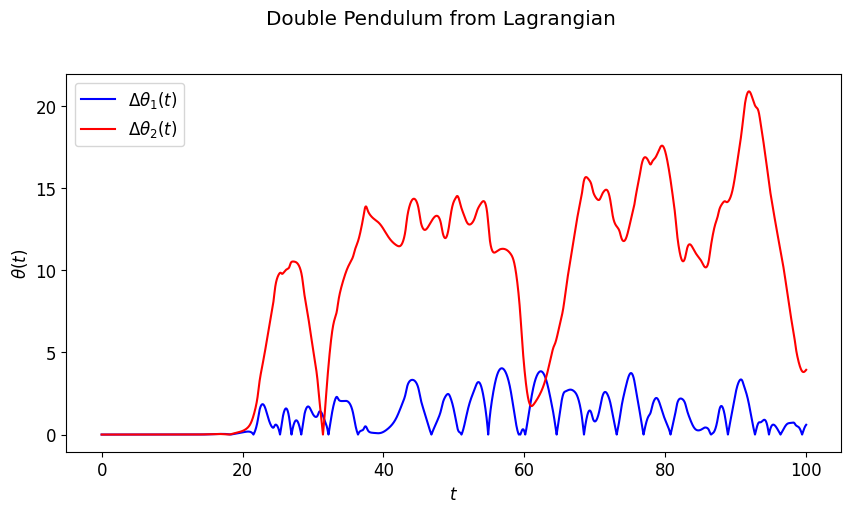

In [10]:
# Define initial conditions
theta1_0 = np.pi / 2
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.

# Find the theta functions
theta1a, theta1a_dot, theta2a, theta2a_dot = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
theta1b, theta1b_dot, theta2b, theta2b_dot = dp1.solve_ode(t_pts, theta1_0+0.0001, theta1_dot_0, theta2_0-0.0001, theta2_dot_0)

# Plot the theta functions
fig = plt.figure(figsize=(10,5))
overall_title = 'Double Pendulum from Lagrangian'
fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(theta1a[start : stop] - theta1b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='blue', 
            label=r'$\Delta\theta_1(t)$', 
            ax=ax_a)
plot_y_vs_x(t_pts[start : stop], np.abs(theta2a[start : stop] - theta2b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='red', 
            label=r'$\Delta\theta_2(t)$', 
            ax=ax_a)    

Once again, there is a very great difference between the two instances of $\theta_2$. This sensitivity to initial conditions is indicitive of chaotic motion.